# Analysis of Pore Network Simulation (random_splitting)

## 1. Setup and Imports

First, we import the necessary Python libraries and set up our plotting style for a clean, scientific look. We also define the path to the simulation output directory.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# --- Configuration ---
OUTPUT_DIR = 'output/'

# Set a scientific plotting style
plt.style.use('seaborn-v0_8-notebook')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

## 2. Helper Functions

We define some helper functions to load the different types of data files our C++ code produces. This keeps the rest of the notebook clean.

In [14]:
def load_histogram(filename, path=OUTPUT_DIR):
    """Loads a 3-column histogram file (index, center, value)."""
    filepath = os.path.join(path, filename)
    try:
        # We need columns 1 (bin_center) and 2 (value)
        data = pd.read_csv(filepath, sep='\t', header=0, comment='#',
                           usecols=[1, 2], names=['q', 'P(q)'], engine='python')
        # Drop any rows where P(q) is 0, as they mess up log plots
        return data[data['P(q)'] > 0].reset_index(drop=True)
    except FileNotFoundError:
        print(f"Warning: File not found: {filepath}")
        return None
    except Exception as e:
        print(f"Warning: Could not load {filepath}. Error: {e}")
        return None

def load_k_data(filename, path=OUTPUT_DIR):
    """Loads a 3-column k-dependent file (k, value, error)."""
    filepath = os.path.join(path, filename)
    try:
        data = pd.read_csv(filepath, sep='\t', header=0, comment='#',
                           names=['k', 'value', 'error'], engine='python')
        return data
    except FileNotFoundError:
        print(f"Warning: File not found: {filepath}")
        return None
    except Exception as e:
        print(f"Warning: Could not load {filepath}. Error: {e}")
        return None

def load_coords(filename, path=OUTPUT_DIR):
    """Loads coordinate files (ID, x, y, ...)."""
    filepath = os.path.join(path, filename)
    try:
        # Load only the first 3 columns (ID, x, y)
        data = pd.read_csv(filepath, sep=' ', header=None, usecols=[0, 1, 2],
                           names=['id', 'x', 'y'])
        return data
    except FileNotFoundError:
        print(f"Warning: File not found: {filepath}")
        return None
    except Exception as e:
        print(f"Warning: Could not load {filepath}. Error: {e}")
        return None

## 3. Flow Distributions (Simulation vs. Analytical)

This is the main analysis from the `nreals` loop. We compare the simulated histograms (pore and tube flow) against the analytical fits (P(q), g(q), f(q)) generated by the Python script, as well as the 'Alim' fit (Method of Moments).

In [15]:
# Load all the necessary data
pore_dist = load_histogram("pore_flow_dist.dat")
tube_dist = load_histogram("tube_flow_dist.dat")
fit_P = load_histogram("analytical_P_fit.dat")
fit_g = load_histogram("analytical_g_fit.dat")
fit_f = load_histogram("analytical_f_fit.dat")

# Create the main plot
if pore_dist is not None and fit_P is not None:
    plt.figure(figsize=(10, 6))
    
    # --- MODIFIED: Changed plot style to 'o-' (line + points) ---
    plt.plot(pore_dist['q'], pore_dist['P(q)'], 'o-', markersize=3, 
             label='Simulation Data (pore_flow_dist.dat)', alpha=0.7)
    
    plt.plot(fit_P['q'], fit_P['P(q)'], 'r-', linewidth=2.5, 
             label='Analytical Fit (P(q))')
    
    plt.title('Pore Flow Distribution vs. Analytical Fit')
    plt.xlabel('Flow Rate (q)')
    plt.ylabel('Probability Density P(q)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.show()
else:
    print("Skipping main flow plot: data files not found.")

Skipping main flow plot: data files not found.


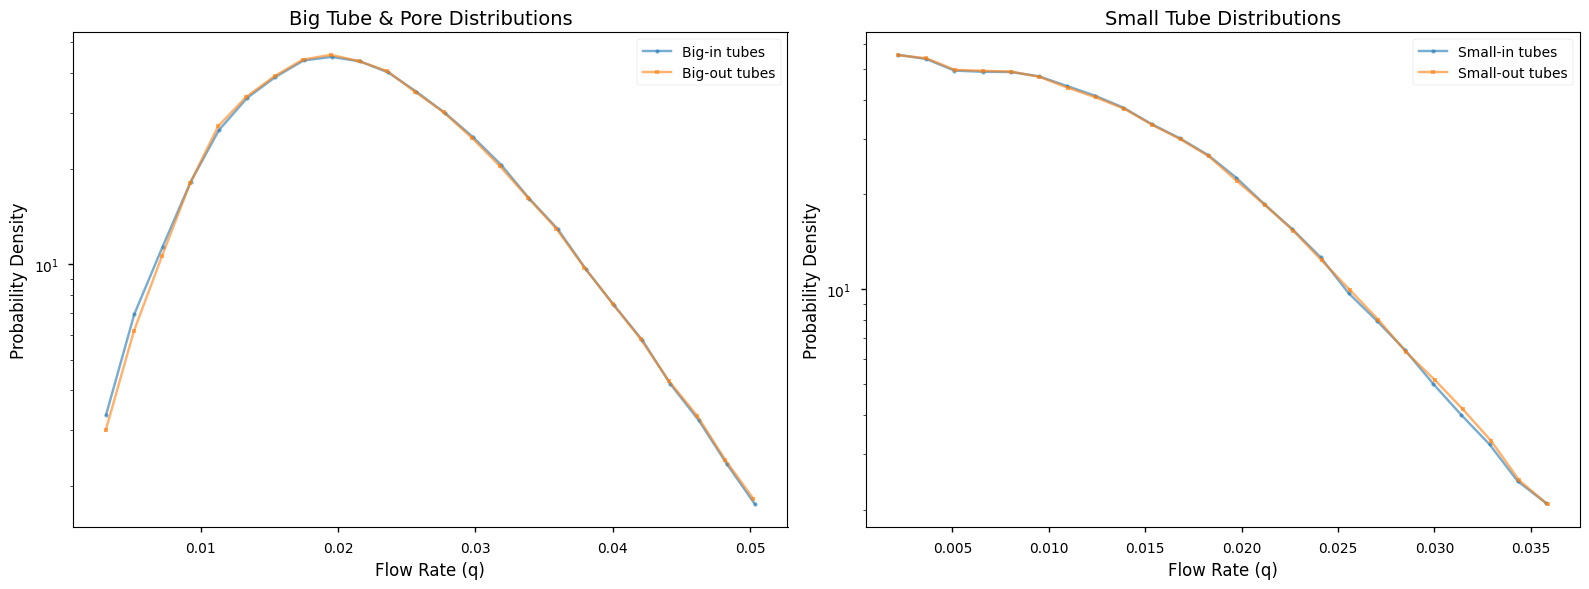

In [16]:
# Load sub-population data
big_in_dist = load_histogram("big_in_tube_flow_dist.dat")
big_out_dist = load_histogram("big_out_tube_flow_dist.dat")
small_in_dist = load_histogram("small_in_tube_flow_dist.dat")
small_out_dist = load_histogram("small_out_tube_flow_dist.dat")
pore1_dist = load_histogram("pore_1_flow_dist.dat")
pore2_dist = load_histogram("pore_2_flow_dist.dat")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- MODIFIED: Changed plot style to 'o-' and 's-' ---

# Plot 1: Big/Pore vs. g(q)
if big_in_dist is not None:
    ax1.plot(big_in_dist['q'], big_in_dist['P(q)'], 'o-', markersize=3, label='Big-in tubes', alpha=0.6)
if big_out_dist is not None:
    ax1.plot(big_out_dist['q'], big_out_dist['P(q)'], 's-', markersize=3, label='Big-out tubes', alpha=0.6)
if fit_g is not None:
    ax1.plot(fit_g['q'], fit_g['P(q)'], 'r-', lw=2, label='Model g(q)')
ax1.set_title('Big Tube & Pore Distributions')
ax1.set_xlabel('Flow Rate (q)')
ax1.set_ylabel('Probability Density')
ax1.set_yscale('log')
ax1.legend()

# Plot 2: Small vs. f(q)
if small_in_dist is not None:
    ax2.plot(small_in_dist['q'], small_in_dist['P(q)'], 'o-', markersize=3, label='Small-in tubes', alpha=0.6)
if small_out_dist is not None:
    ax2.plot(small_out_dist['q'], small_out_dist['P(q)'], 's-', markersize=3, label='Small-out tubes', alpha=0.6)
if fit_f is not None:
    ax2.plot(fit_f['q'], fit_f['P(q)'], 'b-', lw=2, label='Model f(q)')
ax2.set_title('Small Tube Distributions')
ax2.set_xlabel('Flow Rate (q)')
ax2.set_ylabel('Probability Density')
ax2.set_yscale('log')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. k-Dependent Analysis (Correlations)

Here we plot the summary statistics collected from the k-analysis loop. We are looking at how correlations (mass, evenness) evolve with distance `k`.

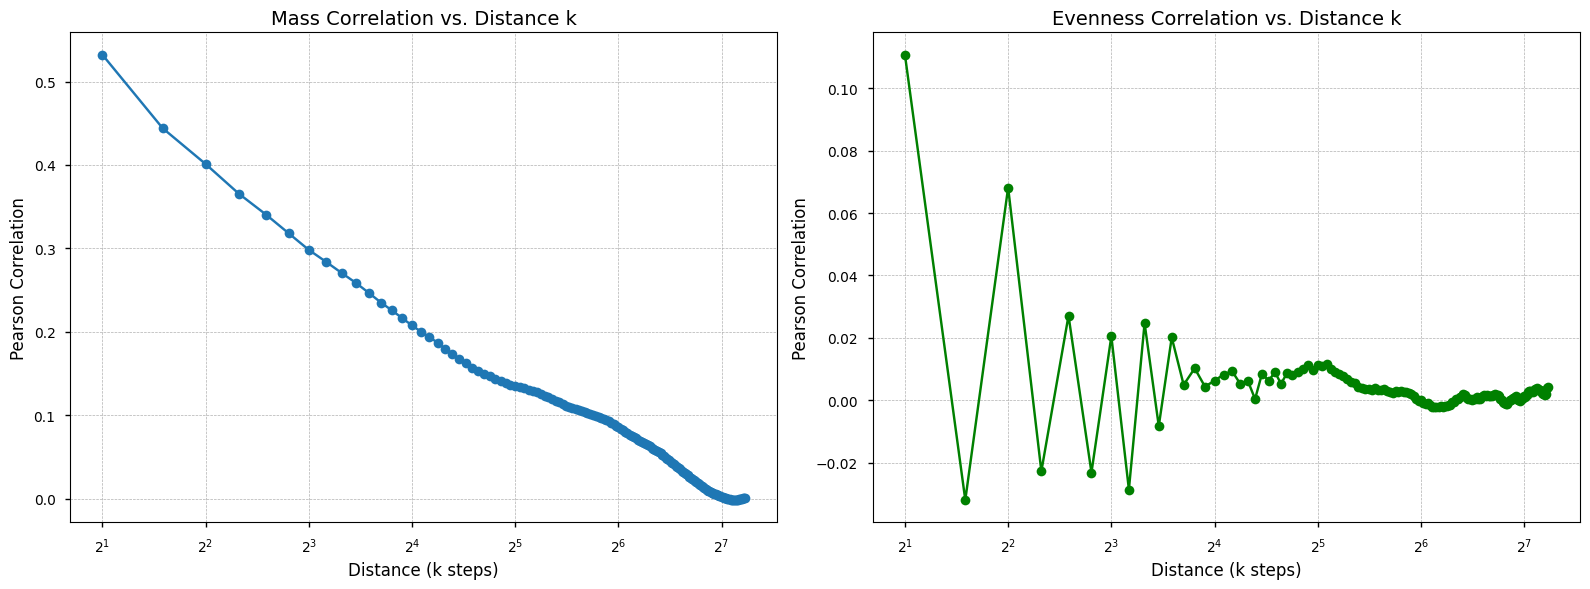

In [17]:
corr_mass_data = load_k_data("k_corr_mass.dat")
corr_evenness_data = load_k_data("k_corr_evenness.dat")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Mass Correlation vs. k
if corr_mass_data is not None:
    ax1.plot(corr_mass_data['k'], corr_mass_data['value'], 'o-')
    ax1.set_title('Mass Correlation vs. Distance k')
    ax1.set_xlabel('Distance (k steps)')
    ax1.set_ylabel('Pearson Correlation')
    ax1.set_xscale('log', base=2)
    # --- MODIFIED: Removed xticks and xticklabels to prevent overlap ---
    ax1.grid(True, which="both", ls="--", lw=0.5)
else:
    ax1.set_title('Mass Correlation Data Not Found')

# Plot 2: Evenness Correlation vs. k
if corr_evenness_data is not None:
    ax2.plot(corr_evenness_data['k'], corr_evenness_data['value'], 'o-', color='green')
    ax2.set_title('Evenness Correlation vs. Distance k')
    ax2.set_xlabel('Distance (k steps)')
    ax2.set_ylabel('Pearson Correlation')
    ax2.set_xscale('log', base=2)
    # --- MODIFIED: Removed xticks and xticklabels to prevent overlap ---
    ax2.grid(True, which="both", ls="--", lw=0.5)
else:
    ax2.set_title('Evenness Correlation Data Not Found')

plt.tight_layout()
plt.show()

## 5. k-Dependent Analysis (Degrees)

Here we plot the average k-th order degrees (exact and cumulative) as a function of distance `k`.

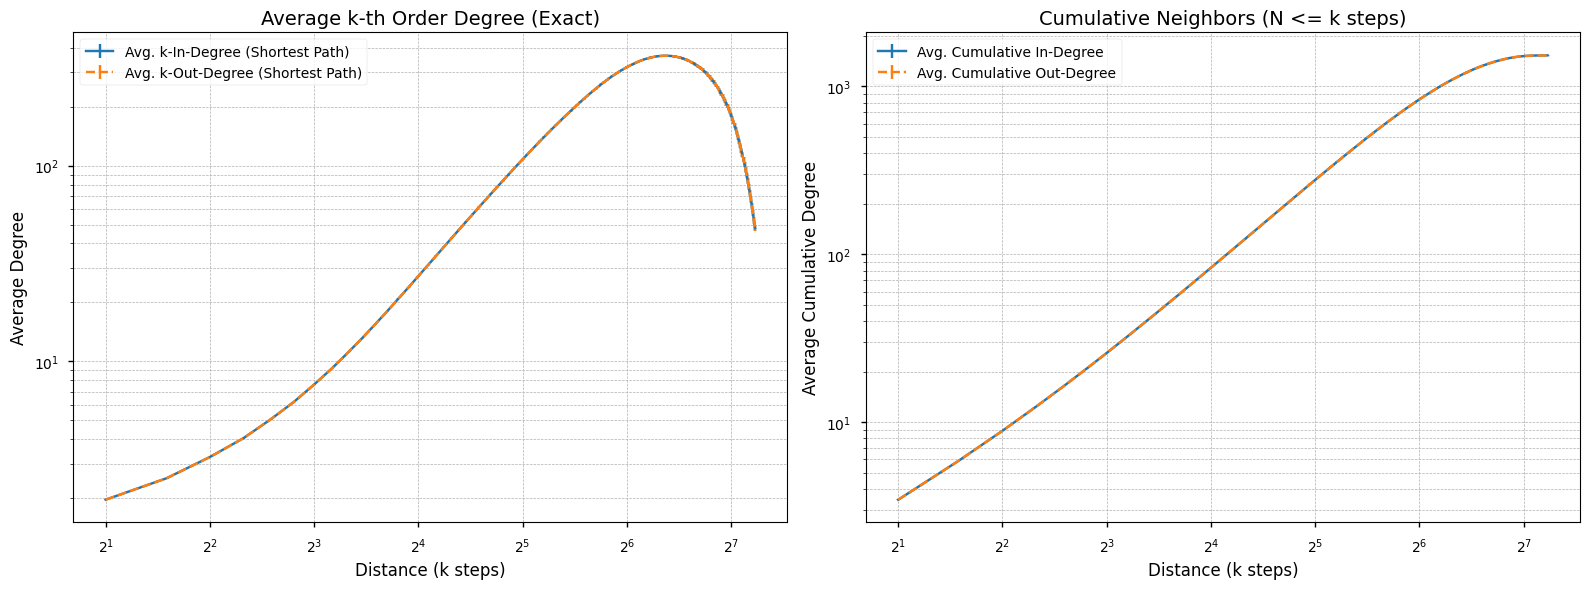

In [18]:
avg_in_deg = load_k_data("k_avg_in_degree.dat")
avg_out_deg = load_k_data("k_avg_out_degree.dat")
avg_cum_in_deg = load_k_data("k_avg_CUM_in_degree.dat")
avg_cum_out_deg = load_k_data("k_avg_CUM_out_degree.dat")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- MODIFIED: Changed format from 'o-' to '-' (lines only) ---

# Plot 1: Exact k-th Order Degree vs. k
if avg_in_deg is not None and avg_out_deg is not None:
    ax1.errorbar(avg_in_deg['k'], avg_in_deg['value'], yerr=avg_in_deg['error'], 
                 fmt='-', capsize=5, label='Avg. k-In-Degree (Shortest Path)')
    ax1.errorbar(avg_out_deg['k'], avg_out_deg['value'], yerr=avg_out_deg['error'], 
                 fmt='--', capsize=5, label='Avg. k-Out-Degree (Shortest Path)')
    ax1.set_title('Average k-th Order Degree (Exact)')
    ax1.set_xlabel('Distance (k steps)')
    ax1.set_ylabel('Average Degree')
    ax1.set_xscale('log', base=2)
    ax1.set_yscale('log')
    # --- MODIFIED: Removed xticks and xticklabels ---
    ax1.legend()
    ax1.grid(True, which="both", ls="--", lw=0.5)
else:
    ax1.set_title('Exact Degree Data Not Found')

# Plot 2: Cumulative k-th Order Degree vs. k
if avg_cum_in_deg is not None and avg_cum_out_deg is not None:
    ax2.errorbar(avg_cum_in_deg['k'], avg_cum_in_deg['value'], yerr=avg_cum_in_deg['error'], 
                 fmt='-', capsize=5, label='Avg. Cumulative In-Degree')
    ax2.errorbar(avg_cum_out_deg['k'], avg_cum_out_deg['value'], yerr=avg_cum_out_deg['error'], 
                 fmt='--', capsize=5, label='Avg. Cumulative Out-Degree')
    ax2.set_title('Cumulative Neighbors (N <= k steps)')
    ax2.set_xlabel('Distance (k steps)')
    ax2.set_ylabel('Average Cumulative Degree')
    ax2.set_xscale('log', base=2)
    ax2.set_yscale('log')
    # --- MODIFIED: Removed xticks and xticklabels ---
    ax2.legend()
    ax2.grid(True, which="both", ls="--", lw=0.5)
else:
    ax2.set_title('Cumulative Degree Data Not Found')

plt.tight_layout()
plt.show()

## 6. Degree Distributions (k=1)

A log-log plot of the in-degree and out-degree (k=1) distributions. This is a classic plot for network analysis.

In [19]:
in_deg_k1 = load_k_data("in_degree_dist_k1.dat") # Uses k_data loader, col names are (k, val, err)
out_deg_k1 = load_k_data("out_degree_dist_k1.dat")

if in_deg_k1 is not None and out_deg_k1 is not None:
    plt.figure(figsize=(10, 6))
    
    # --- MODIFIED: Changed from scatter to plot (lines) ---
    # Note: the 'error' column from load_k_data is P(k)
    plt.plot(in_deg_k1['k'], in_deg_k1['error'], '-', label='In-Degree (k=1)', alpha=0.8)
    plt.plot(out_deg_k1['k'], out_deg_k1['error'], '--', label='Out-Degree (k=1)', alpha=0.8)
    
    plt.title('Degree Distribution (k=1)')
    plt.xlabel('Degree (k)')
    plt.ylabel('Probability P(k)')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.show()
else:
    print("Skipping k=1 degree plot: data files not found.")

Skipping k=1 degree plot: data files not found.


## 7. Other Property Distributions

Plots for the evenness of splitters and the fraction of weights on the links.

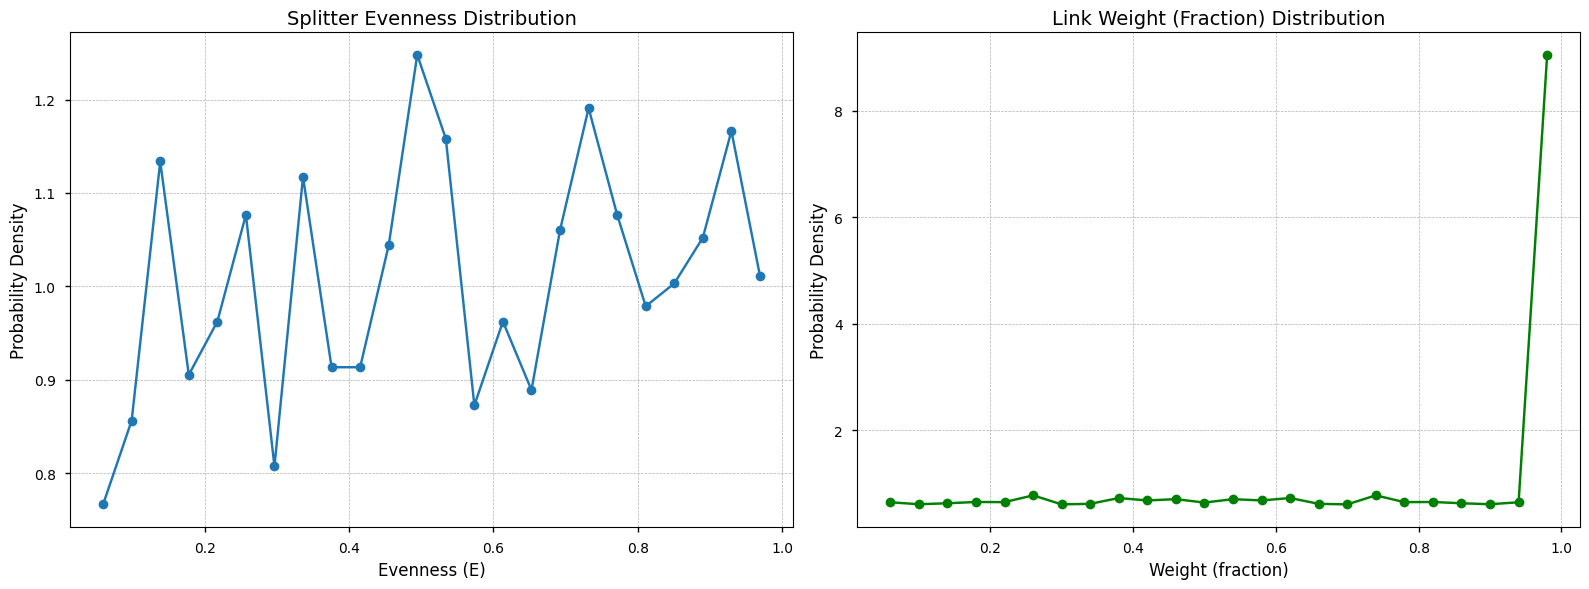

In [20]:
evenness_dist = load_histogram("evenness_dist.dat")
fractions_dist = load_histogram("fractions_dist.dat")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Evenness
if evenness_dist is not None:
    ax1.plot(evenness_dist['q'], evenness_dist['P(q)'], 'o-')
    ax1.set_title('Splitter Evenness Distribution')
    ax1.set_xlabel('Evenness (E)')
    ax1.set_ylabel('Probability Density')
    ax1.grid(True, ls="--", lw=0.5)
else:
    ax1.set_title('Evenness Data Not Found')

# Plot 2: Fractions
if fractions_dist is not None:
    ax2.plot(fractions_dist['q'], fractions_dist['P(q)'], 'o-', color='green')
    ax2.set_title('Link Weight (Fraction) Distribution')
    ax2.set_xlabel('Weight (fraction)')
    ax2.set_ylabel('Probability Density')
    ax2.grid(True, ls="--", lw=0.5)
else:
    ax2.set_title('Fraction Data Not Found')

plt.tight_layout()
plt.show()

## 8. Spatial Plots

A simple scatter plot showing the locations of the inlet and outlet nodes.

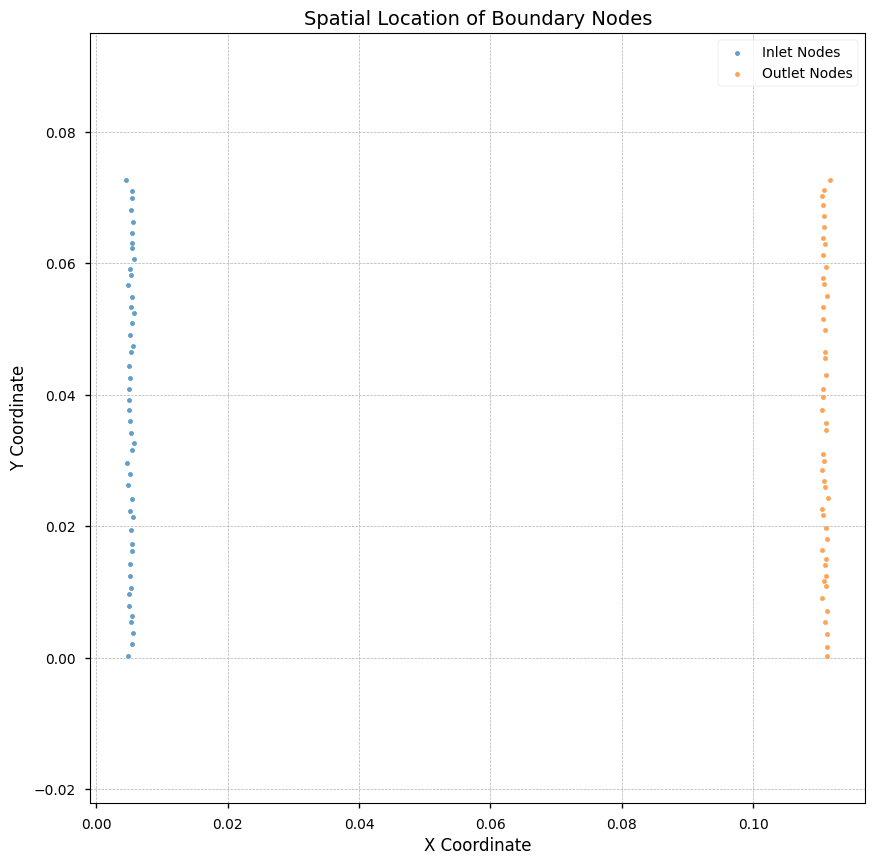

In [21]:
inlet_coords = load_coords("inlet_coordinates.dat")
outlet_coords = load_coords("outlet_coordinates.dat")

if inlet_coords is not None and outlet_coords is not None:
    plt.figure(figsize=(10, 10))
    
    plt.scatter(inlet_coords['x'], inlet_coords['y'], 
                label='Inlet Nodes', s=10, alpha=0.7)
    plt.scatter(outlet_coords['x'], outlet_coords['y'], 
                label='Outlet Nodes', s=10, alpha=0.7)
    
    plt.title('Spatial Location of Boundary Nodes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.axis('equal') # Ensure aspect ratio is 1:1
    plt.grid(True, ls="--", lw=0.5)
    plt.show()
else:
    print("Skipping coordinate plot: data files not found.")